In [415]:
import torch
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import torch.nn.functional as F
from collections import defaultdict
import copy
import sys
from scipy import ndimage
cmap=plt.cm.Spectral_r
from mpl_toolkits import mplot3d
from pathlib import Path
import string

sys.path.append('.')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':16,
    "lines.linewidth":3.0,
    "savefig.dpi":500
})
cmap = plt.get_cmap('Greys')

savedir= './figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

In [2]:
def find(array, value):
    idx= np.argwhere(np.array(array)==value)[0,0]
    return idx

def h2p(width, input_size, depth):
    return input_size*width + (depth-1) * width**2 + width
h2p = np.vectorize(h2p)

def select_runs(runs, params, constraints):
    selected_runs = []
    for irun, run in enumerate(runs):
        keep = True
        for k,v in constraints.items():
            if getattr(run['args'],k) != v:
                keep = False
                break
        if keep:
            selected_runs.append(run)
    selected_params = copy.deepcopy(params)
    for con in constraints:
        selected_params[con]=[constraints[con]]
    return selected_runs, selected_params

def group_runs(runs, finished_only=True):
    runs_grouped = defaultdict(list)
    for run in runs:
        seedless_args = copy.deepcopy(run['args'])
        del(seedless_args.seed)
        del(seedless_args.name)
        if str(seedless_args) not in runs_grouped.keys(): 
            runs_grouped[str(seedless_args)].append(run) # need at least one run
        else:
            if run['finished'] or not finished_only:
                runs_grouped[str(seedless_args)].append(run)
    runs_grouped = list(runs_grouped.values())
    return runs_grouped


In [489]:
# 1610892401 varying number of local layers
# 1610894815 subsampling 
# 1610922944 class token
# 1611084047 width and distance


runs = []
logs = []
indices = [-1]

for ind in indices:

    base = '/checkpoint/sdascoli/deit/'
    paths = sorted(glob.glob(base+'*'), key=os.path.getmtime)
    paths=[p for p in paths if os.path.isdir(p)]
    print(paths)
    last = paths[ind]
    path = last
    #path = base+'r.1604516551'
    path += '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = [p for p in dirnames if (os.path.isdir(p) and not p.endswith('__'))]
    print('{} runs found'.format(len(dirnames)))
    print(*dirnames, end='\n')
    fails = 0
    for dirname in dirnames:
        try : 
            run = {}
            args = torch.load(dirname+'/args.pyT', map_location=torch.device('cpu'))
            run['args'] = args
            f = open(dirname+'/log.txt', "r")
            log = [eval(line) for line in f.readlines()]
            run['logs']=log
            runs.append(run)
        except: 
            print('failed {}'.format(dirname))
            fails += 1
    print('{} fails'.format(fails))
    
latest = min([len(run['logs']) for run in runs])-1
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    params[k] = sorted(list(set(params[k])))
#print(runs[0]['args'])

['/checkpoint/sdascoli/deit/1610922944', '/checkpoint/sdascoli/deit/1610892401', '/checkpoint/sdascoli/deit/1610894815', '/checkpoint/sdascoli/deit/1611084047', '/checkpoint/sdascoli/deit/1611143487', '/checkpoint/sdascoli/deit/1611141078', '/checkpoint/sdascoli/deit/1611153949', '/checkpoint/sdascoli/deit/1611156828']
/checkpoint/sdascoli/deit/1611156828/
9 runs found
/checkpoint/sdascoli/deit/1611156828/dim_1_strength0.1 /checkpoint/sdascoli/deit/1611156828/dim_1_strength0.5 /checkpoint/sdascoli/deit/1611156828/dim_1_strength1 /checkpoint/sdascoli/deit/1611156828/dim_5_strength0.1 /checkpoint/sdascoli/deit/1611156828/dim_5_strength0.5 /checkpoint/sdascoli/deit/1611156828/dim_5_strength1 /checkpoint/sdascoli/deit/1611156828/dim_10_strength0.1 /checkpoint/sdascoli/deit/1611156828/dim_10_strength0.5 /checkpoint/sdascoli/deit/1611156828/dim_10_strength1
failed /checkpoint/sdascoli/deit/1611156828/dim_10_strength1
1 fails


# Varying number of local layers

In [ ]:
topk=5

plt.figure()
times = range(20,latest-1,(latest-20)//5-1)
x, y = [], defaultdict(list)
for run in runs:
    x.append(run['args'].local_up_to_layer)
    for t in times:
        y[t].append(run['logs'][t]['test_acc{}'.format(topk)])
#plt.annotate('Baseline',(min(x)+.1,min(y)+.1), color='red')
    
for t in times:
    plt.plot(x,y[t], marker='o', label='{} epochs'.format(t))
plt.legend()
plt.xlabel('Number of local layers')
plt.ylabel('Top-{} acc'.format(topk,latest))
plt.show()

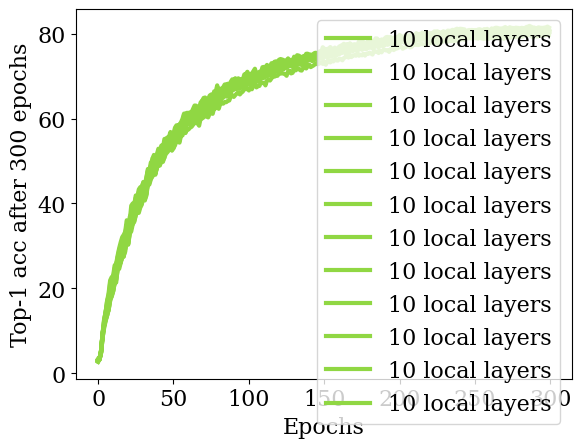

In [125]:
topk=1

plt.figure()
for run in runs:
    n_local = run['args'].local_up_to_layer
    latest = len(run['logs'])
    plt.plot(range(latest), [run['logs'][k]['test_acc%d'%topk] for k in range(latest)], color=cmap(n_local/12), label='{} local layers'.format(n_local))
    #plt.plot(range(latest), [run['test'][k]['loss'] for k in range(latest)], color=cmap(n_local/12), label='{} local layers'.format(n_local))
    #plt.plot(range(latest), [run['train'][k]['loss'] for k in range(latest)], ls='--', color=cmap(n_local/12))
    
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-{} acc after {} epochs'.format(topk,latest))
plt.show()

# Varying sampling ratio

[300, 300]
0.01 300
[300, 300]
0.05 300
[300, 300]
0.1 300
[88, 212]
0.5 88
[128, 122]
1.0 122


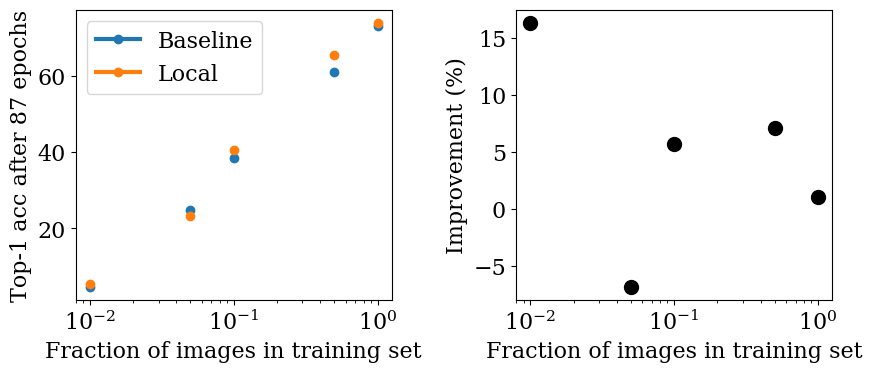

In [631]:
topk=1

fig, axarr = plt.subplots(1,2, figsize=(9,4))

x = defaultdict(list)
y = defaultdict(list)
colors = {False:'C0', True:'C1'}

for i, sampling_ratio in enumerate(params['sampling_ratio']):
    selected_runs, _ = select_runs(runs, params, {'sampling_ratio':sampling_ratio})
    time = min([len(run['logs']) for run in selected_runs])
    print([len(run['logs']) for run in selected_runs])
    print(sampling_ratio, time)
    perfs = {}
    for run in selected_runs:
        local = bool(run['args'].local_up_to_layer)
        perfs[local] = run['logs'][time-1]['test_acc1']
        axarr[0].plot(sampling_ratio, run['logs'][time-1]['test_acc1'], marker='o',
                         color=colors[local], label=(('Local' if local else 'Baseline') if i==0 else ''))
    axarr[1].plot(sampling_ratio, (perfs[True]-perfs[False])/perfs[False]*100, 
                  ls='none', marker='.', ms=20, color='k')
#y[True], y[False] = np.array(y[True]), np.array(y[False])

#for k in x.keys():
#    axarr[0].plot(x[k],y[k], ls='none', marker='.', ms=20, label=('Local' if k else 'Baseline'))
#    axarr[1].plot(x[False],(np.array(y[True])-np.array(y[False]))/np.array(y[False])*100, 
#                  ls='none', marker='.', ms=20, color='k')
for ax in axarr:
    ax.set_xscale('log')    
    ax.set_xlabel('Fraction of images in training set')
axarr[0].legend()
axarr[0].set_ylabel('Top-{} acc after {} epochs'.format(topk,latest))
axarr[1].set_ylabel('Improvement (%)'.format(topk))
plt.tight_layout()
plt.show()

152


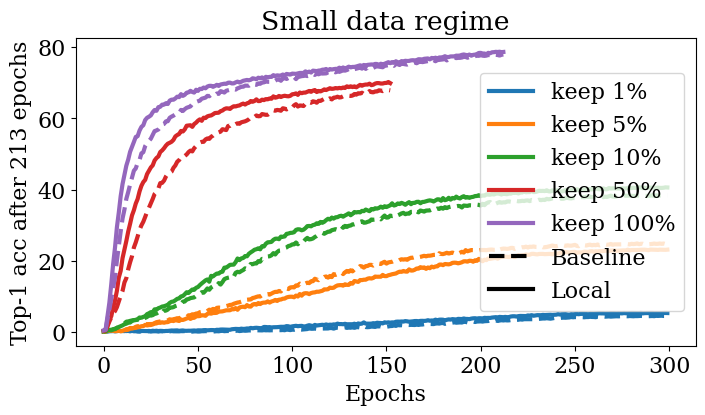

In [48]:
latest = min([len(run['logs']) for run in runs])-1
print(latest)
topk=1

plt.figure(figsize=(8,4))

for i, sampling_ratio in enumerate(params['sampling_ratio']):
    selected_runs, _ = select_runs(runs, params, {'sampling_ratio':sampling_ratio})
    latest = min([len(run['logs']) for run in selected_runs])
    for run in selected_runs:
        local = run['args'].local_up_to_layer
        plt.plot(range(latest), [run['logs'][k]['test_acc1'] for k in range(latest)], ls='-' if local else '--', 
                 label=('keep {0:.0f}%'.format(sampling_ratio*100)) if local else '',
                color = 'C%d'%i)

plt.plot([],[],color='k',label='Baseline', ls='--')
plt.plot([],[],color='k',label='Local')
plt.title('Small data regime')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-{} acc after {} epochs'.format(topk,latest))
plt.show()

# Grid search

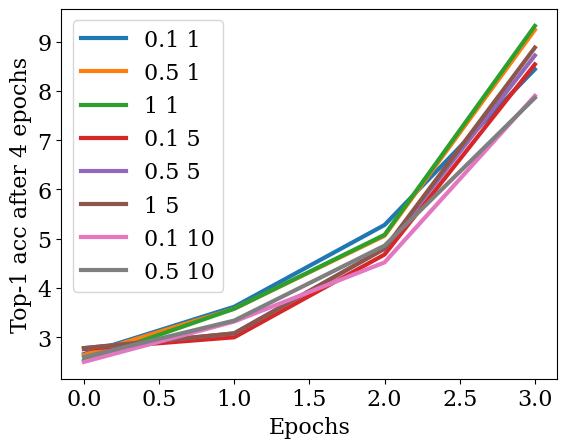

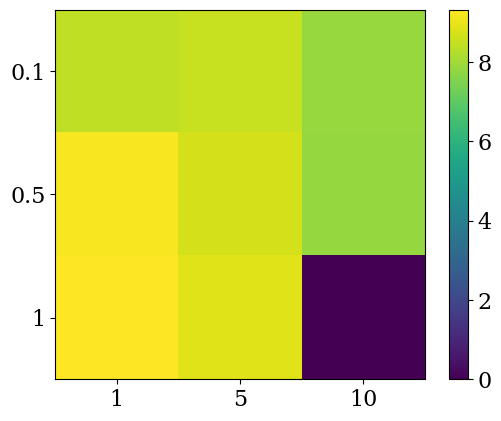

In [490]:
latest = min([len(run['logs']) for run in runs])
topk=1
#key1 = 'local_dim'
#key2 = 'locality_distance'
key1 = 'local_up_to_layer'
key2 = 'freeze_locality'
key1 = 'locality_strength'
key2 = 'locality_dim'

plt.figure()
grid = np.zeros((len(params[key1]),len(params[key2])))
for run in runs:
    args = run['args']
    i,j = find(getattr(args,key1), params[key1]), find(getattr(args,key2), params[key2])
    grid[i,j] = run['logs'][latest-1]['test_acc%d'%topk]
    plt.plot(range(latest), [run['logs'][k]['test_acc%d'%topk] for k in range(latest)], label='{} {}'.format(getattr(args,key1), getattr(args, key2)))    
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-{} acc after {} epochs'.format(topk,latest))
plt.show()

plt.figure()
plt.imshow(grid)
plt.gca().set_xticks(range(len(params[key2])))
plt.gca().set_yticks(range(len(params[key1])))
plt.gca().set_xticklabels(params[key2])
plt.gca().set_yticklabels(params[key1])
plt.colorbar()
plt.show()

# Model size

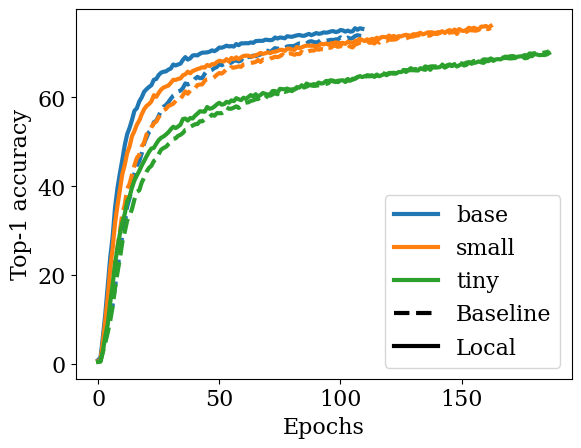

In [156]:
topk=1

plt.figure()

for i, model in enumerate(params['model']):
    selected_runs, _ = select_runs(runs, params, {'model':model})
    latest = min([len(run['logs']) for run in selected_runs])
    for run in selected_runs:
        local = run['args'].local_up_to_layer
        plt.plot(range(latest), [run['logs'][k]['test_acc1'] for k in range(latest)], ls='-' if local else '--', 
                 label=(model.split('_')[1]) if local else '',
                color = 'C%d'%i)

plt.plot([],[],color='k',label='Baseline', ls='--')
plt.plot([],[],color='k',label='Local')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-{} accuracy'.format(topk))
plt.show()

# Attention maps

In [459]:
from main import create_model, build_dataset

cons = {'model': 'deit_tiny_patch16_224',
        'local_up_to_layer' : 10,
        'locality_strength':1
       }
selected_runs, _ = select_runs(runs, params, cons)
run = selected_runs[0]
args = run['args']
model = create_model(args.model, local_up_to_layer=args.local_up_to_layer, num_classes=args.nb_classes)
model.to('cuda')

args = run['args']
args.sampling_ratio = 0.001
dataset, _ = build_dataset(is_train=False, args=args)
x = torch.stack([dataset[i][0] for i in range(20)])
x = x.cuda()
x = model.patch_embed(x)

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, color='red', lw=3, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

def plot_attention(model,x,num_layers=4):
    
    num_patches = model.num_patches
    img_size = int(num_patches**.5)
    num_heads = model.blocks[0].attn.num_heads
    embed_dim = model.embed_dim

    fig, axarr = plt.subplots(num_layers, num_heads, figsize=(1.5*num_heads,1.5*num_layers))

    cols = ['Head {}'.format(col+1) for col in range(num_heads)]
    rows = ['Layer {}'.format(row+1) for row in range(num_layers)]
    for ax, col in zip(axarr[0], cols):
        ax.set_title(col)
    for ax, row in zip(axarr[:,0], rows):
        ax.set_ylabel(row, size='large')


    for l in range(num_layers):
        dist, attn_map = model.blocks[l].attn.get_attention_map(x, return_map=True)
        print(dist)
        num_heads = len(attn_map)
        for head in range(num_heads):
            head_map = attn_map[head,num_patches//2+img_size//2].detach().cpu().resize(img_size,img_size)
            axarr[l,head].matshow(head_map)
            #print(head_map)
        for ax in axarr[l]:
            ax.set_xticks([]) 
            ax.set_yticks([]) 
            highlight_cell(img_size//2, img_size//2,ax)
    plt.tight_layout()
    #plt.savefig(savedir+'attention_map_final_{}.pdf'.format('local' if local_up_to_layer else 'nonlocal'))
    plt.show()

/checkpoint/sdascoli/deit/1611156828/dim_1_strength1/checkpoint.pth
8.283299037388392
8.26793063416773
8.284697863520408
8.281598772321429


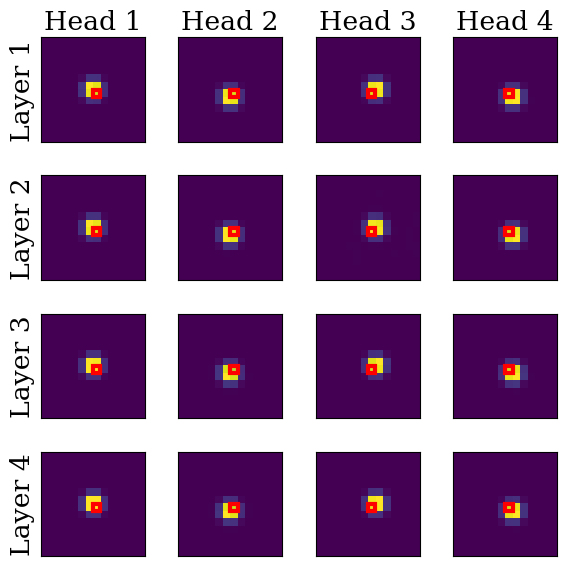

In [460]:
for path in glob.glob(str(args.output_dir/'checkpoint*')):
    print(path)
    state_dict = torch.load(path)["model"]
    model.load_state_dict(state_dict)

    plot_attention(model, x, num_layers=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
5.44386135801977
7.280024314413265


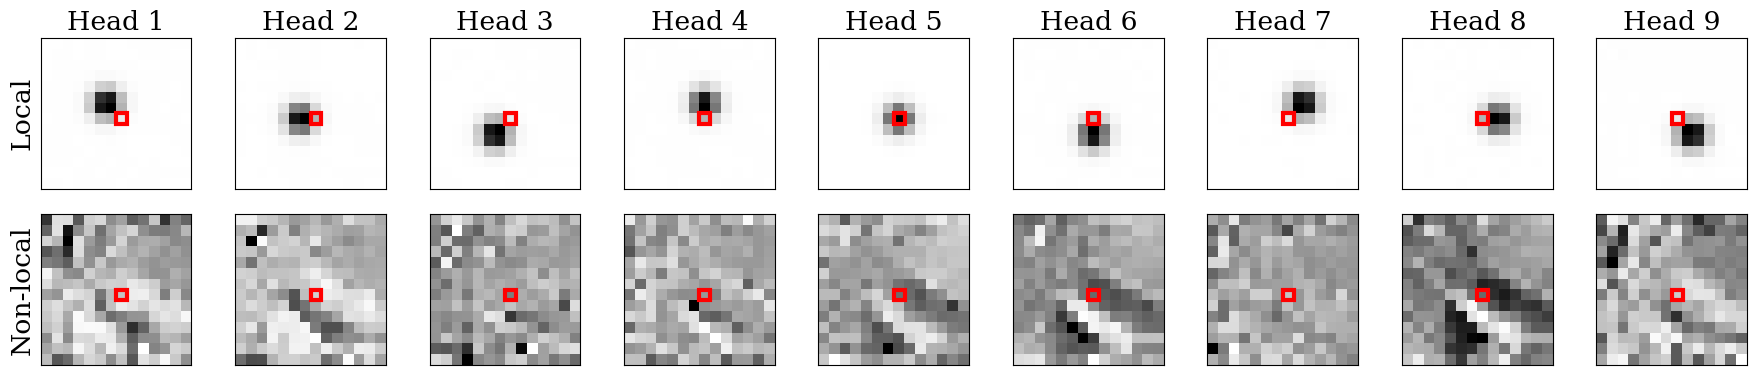

In [488]:
%load_ext autoreload
from main import create_model, build_dataset
strength = 0.5
model = create_model('deit_small_patch16_224', local_up_to_layer=1, locality_strength=strength, locality_dim=1)
model.to('cuda')
num_patches = model.num_patches
img_size = int(num_patches**.5)
num_heads = model.blocks[0].attn.num_heads
embed_dim = model.embed_dim

x = torch.stack([dataset[i][0] for i in range(1)])
x = x.cuda()
x = model.patch_embed(x)

num_layers=2
fig, axarr = plt.subplots(num_layers, num_heads, figsize=(2*num_heads,2*num_layers))
cols = ['Head {}'.format(col+1) for col in range(num_heads)]
rows = ['Local', 'Non-local']
for ax, col in zip(axarr[0], cols):
    ax.set_title(col)
for ax, row in zip(axarr[:,0], rows):
    ax.set_ylabel(row, size='large')
    
num_layers=2
for l in range(num_layers):
    dist, attn_map = model.blocks[l].attn.get_attention_map(x, return_map=True)
    print(dist)
    num_heads = len(attn_map)
    for head in range(num_heads):
        head_map = attn_map[head,num_patches//2+img_size//2].detach().cpu().resize(img_size,img_size)
        #print(head_map.sum())
        axarr[l,head].matshow(head_map, cmap=cmap)
    for ax in axarr[l]:
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        highlight_cell(img_size//2, img_size//2,ax)
plt.tight_layout()

#plt.savefig(savedir+'attention_map_init.pdf')
plt.show()

In [255]:
args = runs[2]['args']
print(args.freeze_locality)
w = torch.load(args.output_dir/'checkpoint_10.pth')['model']
print(w['blocks.0.attn.pos_proj.weight'])

1
tensor([[-4.6967, -4.7284, -1.0508],
        [-4.7150,  4.7713, -1.0436],
        [ 4.7452, -4.8082, -1.0056],
        [ 4.6640,  4.7841, -1.0350]], device='cuda:0')
